In [1]:
!pip install swig

In [9]:
!pip install "gymnasium[box2d]"

In [10]:
!pip install "gymnasium[accept-rom-license]"

In [11]:
!pip install pyvirtualdisplay

In [12]:
!pip install pyglet

In [1]:
import gymnasium as gym
env = gym.make("LunarLander-v3", render_mode = "rgb_array",continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [2]:
obs = env.reset()

In [3]:
print(obs)

(array([-0.00312195,  1.4131066 , -0.31623474,  0.09718189,  0.00362436,
        0.07163189,  0.        ,  0.        ], dtype=float32), {})


In [4]:
img = env.render()

In [5]:
import matplotlib.pyplot as plt

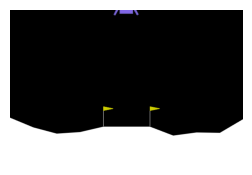

In [6]:
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
action = env.action_space.sample()

In [8]:
env.step(action)

(array([-0.00627699,  1.4161243 , -0.3189326 ,  0.13411383,  0.00702284,
         0.06797642,  0.        ,  0.        ], dtype=float32),
 -2.4579798220791984,
 False,
 False,
 {})

In [9]:
observation, reward, done, truncated, info = env.step(action)

In [10]:
observation

array([-0.00939426,  1.4196454 , -0.3153663 ,  0.15646788,  0.01062582,
        0.0720659 ,  0.        ,  0.        ], dtype=float32)

In [11]:
reward

-1.620623896546124

In [12]:
done

False

In [13]:
truncated

False

In [14]:
info

{}

In [15]:
#o - observation
o= env.reset()

In [16]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

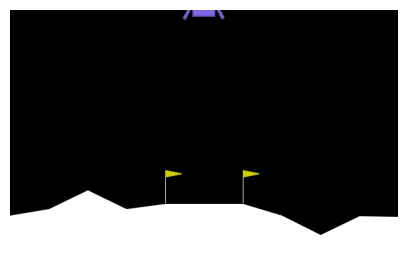

In [17]:
# creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [ ]:
#DQN

In [18]:
env.observation_space.shape

(8,)

In [23]:
env.observation_space.shape[0]

8

In [25]:
import tensorflow as tf

input_shape = [env.observation_space.shape[0]] # == env.observation_space.shape
n_outputs = env.action_space.n # == env.action_space.n
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

/Users/rebecca/anaconda3/envs/mac_n2c/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-03 21:20:00.476619: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-03 21:20:00.476637: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-03 21:20:00.476643: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-03 21:20:00.476985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 21:20:00.476995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:2

In [32]:
import numpy as np
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax() # optimal action according to the DQN

In [33]:
from collections import deque
replay_buffer = deque(maxlen=2000)

In [34]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ] # [states, actions, rewards, next_states, dones, truncateds]

In [35]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [62]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    
    # Calculate Q-values for the next states
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)

    # Handle episode terminations correctly
    runs = 1.0 - (dones.astype(float) + truncateds.astype(float)) # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Create action masks for the Q-values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [63]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200): # Maximum steps per episode
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
            
    if episode > 50:
        training_step(batch_size)

In [64]:
# this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [65]:
import matplotlib.animation

frames = []
observation = env.reset()
for _ in range(500):
    frames.append(env.render())
    action = epsilon_greedy_policy(observation, epsilon = 1.0)
    # your agent here (this takes random actions)
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated :
        observation = env.reset()
env.close()
plot_animation(frames)

In [66]:
from IPython.display import HTML

HTML(plot_animation(frames).to_html5_video())